# 1. Data Analysis:

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, f_classif ,chi2
from sklearn.metrics import f1_score, classification_report, confusion_matrix, confusion_matrix
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


In [320]:
# Load the dataset
df = pd.read_csv('Static_dataset.csv')

print(df.head())

  timestamp  FQDN_count  subdomain_length  upper  lower  numeric   entropy  \
0   56:19.8          27                10      0     10       11  2.570417   
1   07:23.9          27                10      0     10       11  2.767195   
2   23:15.1          26                 9      0     10       10  2.742338   
3   04:51.9          27                10      0     10       11  2.570417   
4   12:44.0          15                 9      0     11        0  2.929439   

   special  labels  labels_max  labels_average longest_word    sld  len  \
0        6       6           7        3.666667            2    192   14   
1        6       6           7        3.666667            2    192   14   
2        6       6           7        3.500000            2    192   13   
3        6       6           7        3.666667            2    192   14   
4        4       3           5        4.333333        local  local   15   

   subdomain  Target Attack  
0          1              1  
1          1        

In [107]:
# Check basic statistics
print(df.describe())

          FQDN_count  subdomain_length          upper          lower  \
count  268074.000000     268074.000000  268074.000000  268074.000000   
mean       22.286596          6.059021       0.845420      10.410014   
std         6.001205          3.899505       4.941929       3.207725   
min         2.000000          0.000000       0.000000       0.000000   
25%        18.000000          3.000000       0.000000      10.000000   
50%        24.000000          7.000000       0.000000      10.000000   
75%        27.000000         10.000000       0.000000      10.000000   
max        36.000000         23.000000      32.000000      34.000000   

             numeric        entropy        special         labels  \
count  268074.000000  268074.000000  268074.000000  268074.000000   
mean        6.497586       2.485735       4.533577       4.788823   
std         4.499866       0.407709       2.187683       1.803256   
min         0.000000       0.219195       0.000000       1.000000   
25%   

In [108]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64


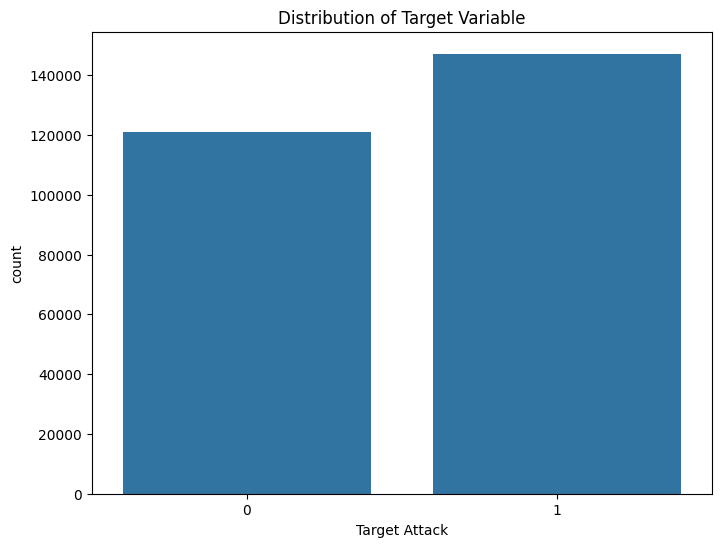

Target Attack
1    147179
0    120895
Name: count, dtype: int64


In [216]:
# Check the imbalance of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='Target Attack', data=df)
plt.title('Distribution of Target Variable')
plt.show()

# Print the numbers of each class in the 'Target Attack' column
class_counts = df['Target Attack'].value_counts()
print(class_counts)


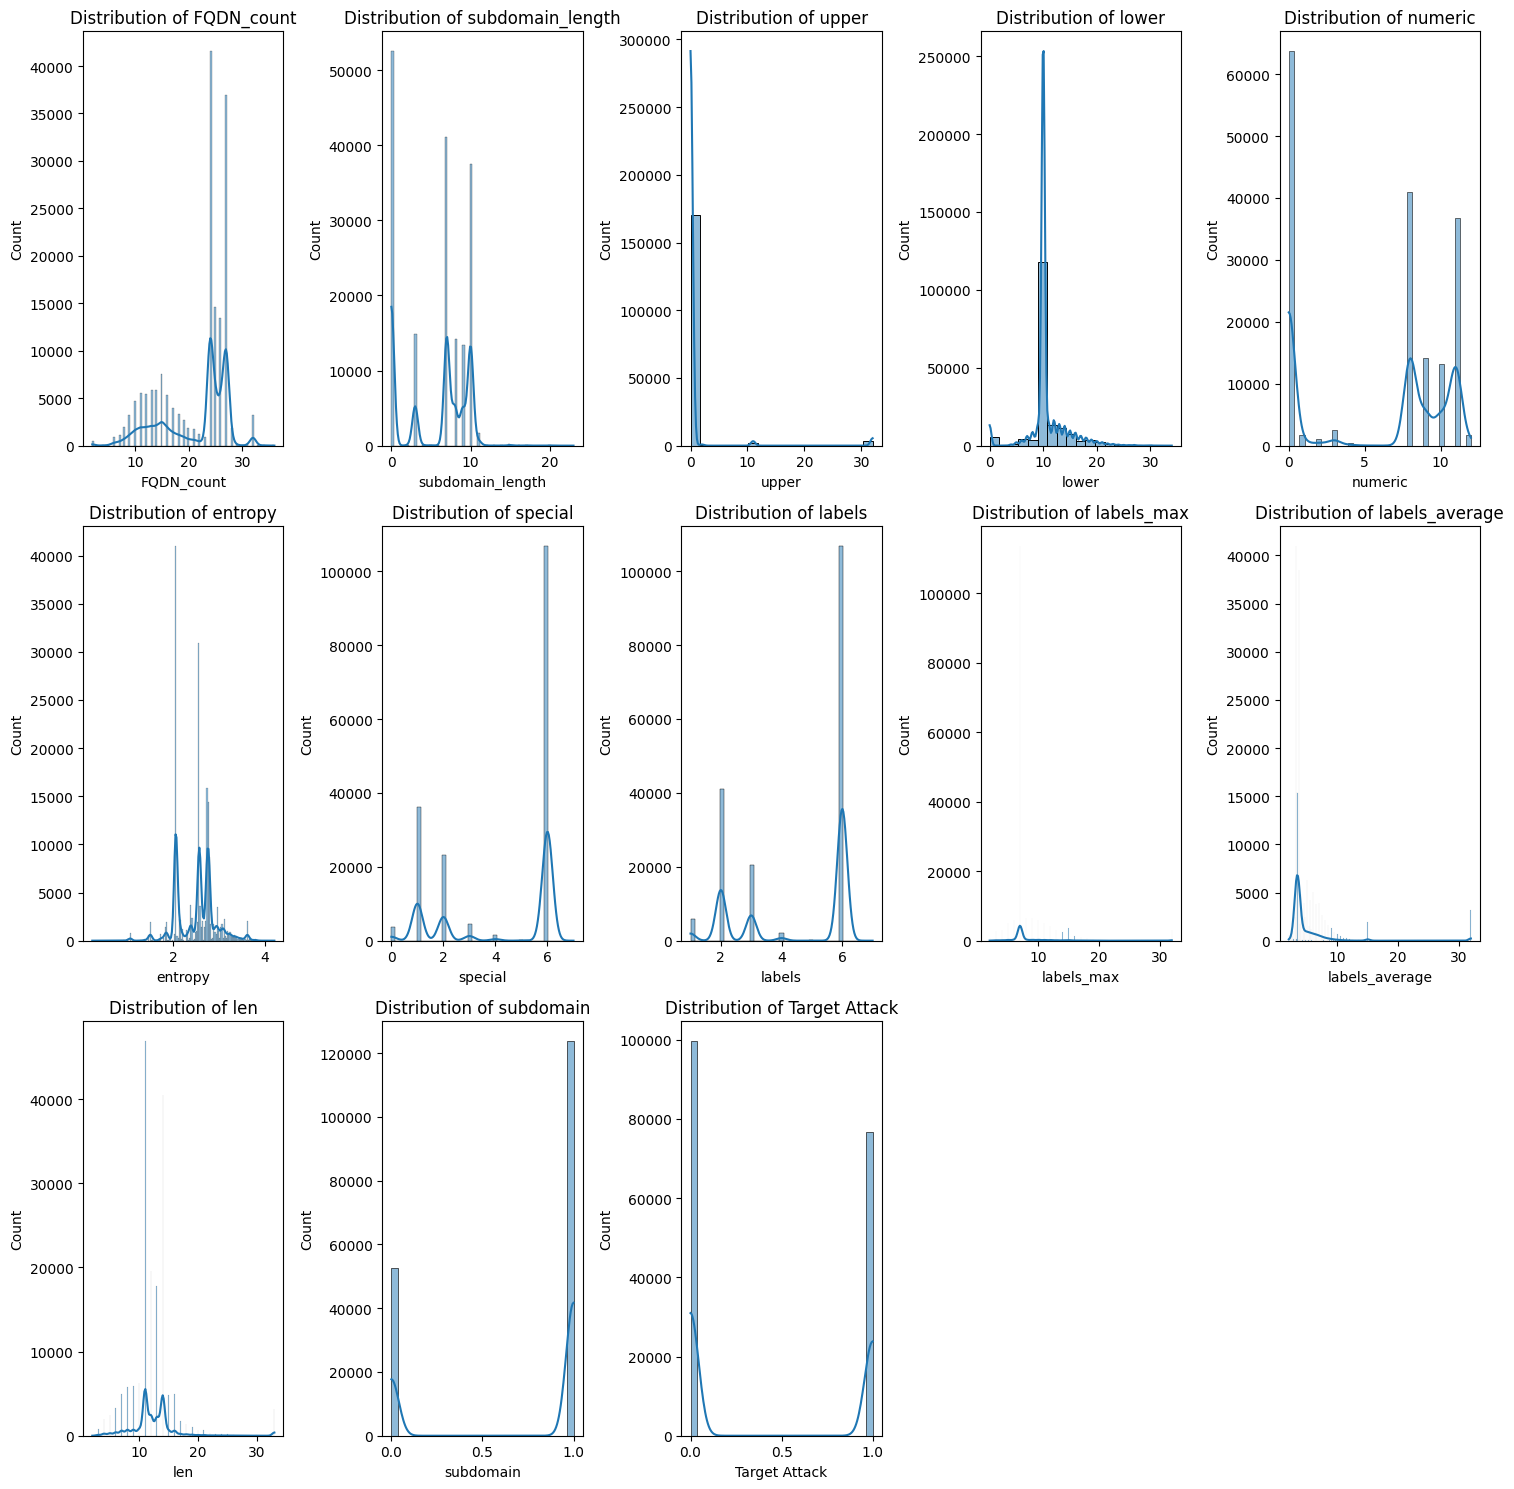

In [113]:
# Check the distribution and skewness of numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

num_plots = len(numerical_features)
num_cols = 5  # Set the number of plots per row

# Calculate the number of rows needed
num_rows = -(-num_plots // num_cols)

plt.figure(figsize=(15, 5 * num_rows))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_2516\2315524161.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=axes[row, col], kde=False, color='blue')


FQDN_count: Skewness = -0.80
subdomain_length: Skewness = -0.31
upper: Skewness = 6.63
lower: Skewness = 0.56
numeric: Skewness = -0.30
entropy: Skewness = -0.10
special: Skewness = -0.57
labels: Skewness = -0.57
labels_max: Skewness = 3.68
labels_average: Skewness = 5.21
len: Skewness = 2.30
subdomain: Skewness = -0.88
Target Attack: Skewness = 0.26


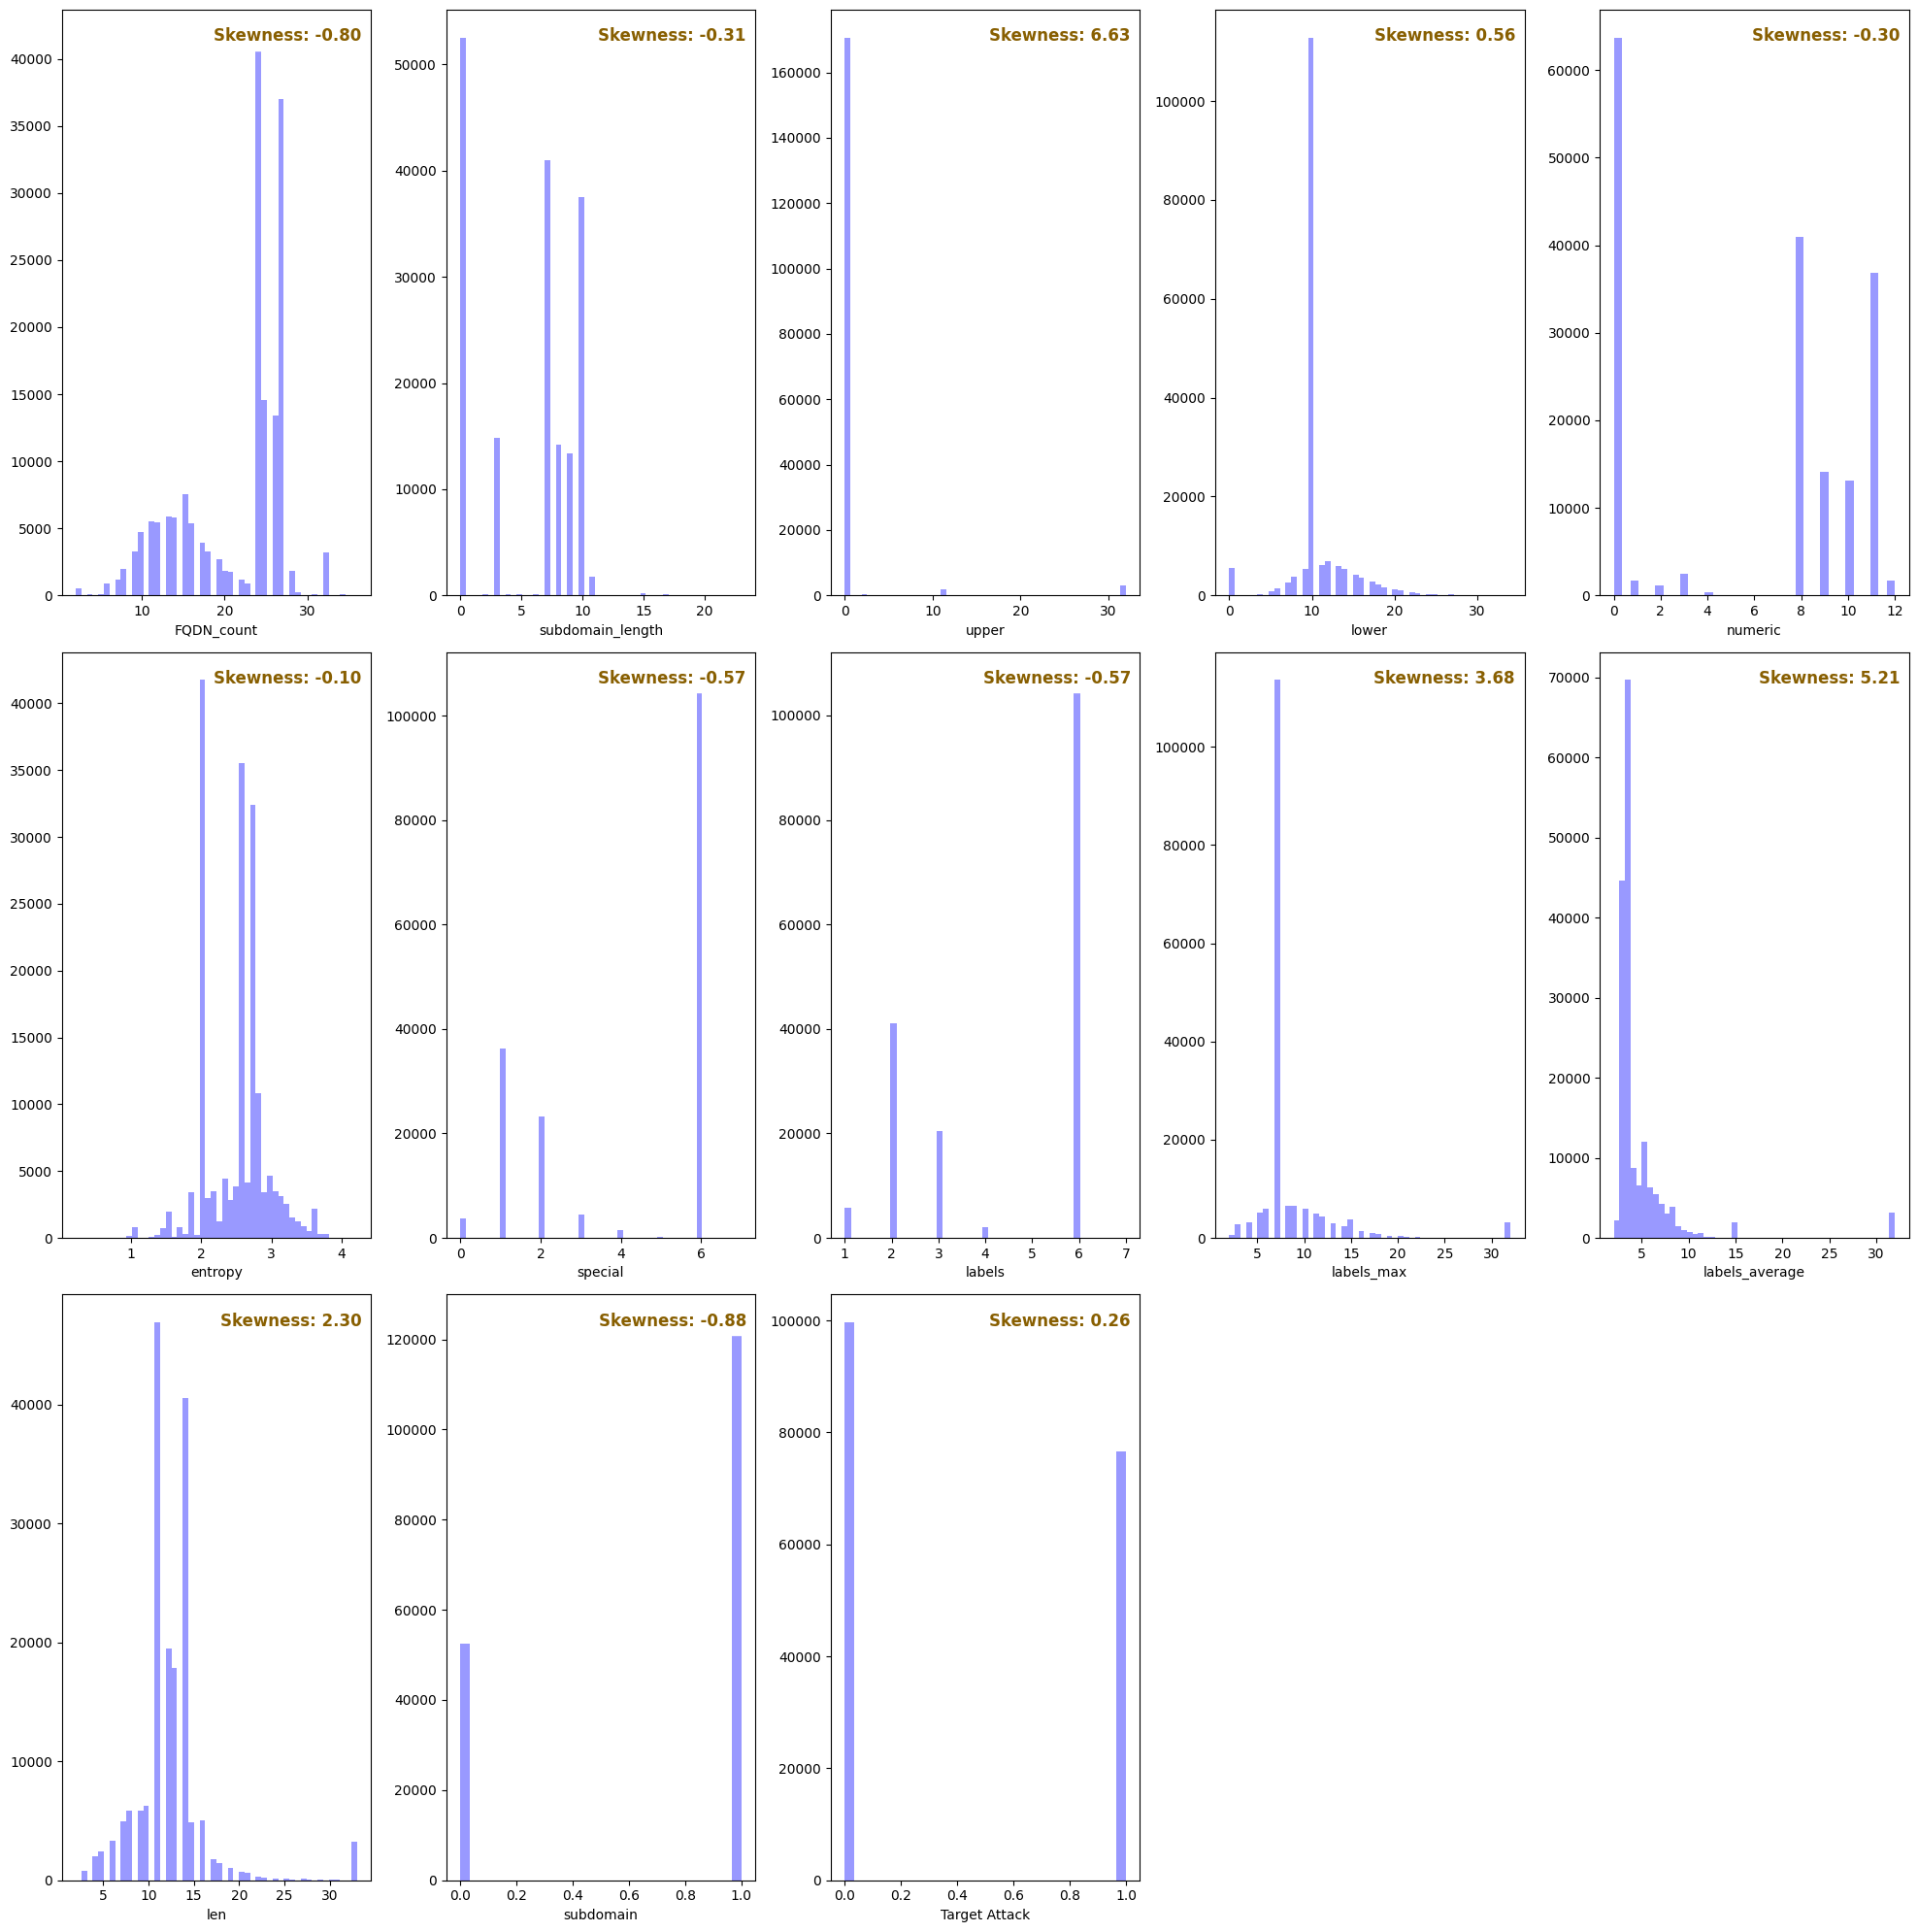

In [114]:
numeric_columns = df.select_dtypes(include=['number']).columns
num_cols = 5
num_rows = -(-len(numeric_columns) // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), sharex=False)

for i, column in enumerate(numeric_columns):
    row, col = divmod(i, num_cols)

    sns.distplot(df[column], ax=axes[row, col], kde=False, color='blue')
    skewness = df[column].skew()
    axes[row, col].text(
        x=0.97, y=0.97, transform=axes[row, col].transAxes,
        s=f'Skewness: {skewness:.2f}',
        fontweight='demibold', fontsize=12, verticalalignment='top',
        horizontalalignment='right', backgroundcolor='white',
        color='xkcd:poo brown'
    )

    # Print feature name and skewness value
    print(f"{column}: Skewness = {skewness:.2f}")

# Remove empty subplots if there are more than needed
for i in range(len(numeric_columns), num_rows * num_cols):
    fig.delaxes(axes.ravel()[i])

plt.tight_layout()
plt.show()


# 2. Feature engineering and data cleaning:

In [321]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)
# Replace string values with the most common number in each column
for column in string_columns:
    most_common_value = df[column].mode()[0]
    df[column] = df[column].apply(lambda x: most_common_value if isinstance(x, str) else x)


Index(['timestamp', 'longest_word', 'sld'], dtype='object')


In [322]:
# Define your target variable (y) and feature matrix (X)
y = df['Target Attack']  # Replace 'Target Attack' with the actual name of your target column
X = df.drop(columns=['Target Attack', 'timestamp'])

# Step 3: Split the Data
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale the features using StandardScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train1)
X_test = scaler.transform(X_test1)

In [323]:
X_train = pd.DataFrame(X_train, columns=X_train1.columns)
X_test = pd.DataFrame(X_test, columns=X_test1.columns)

# 3. Feature Filtering/Selection:

In [325]:
# List to store Random Forest F1 scores
models_f1_scores_rf = []

# List to store Logistic Regression F1 scores
models_f1_scores_lr = []

# Dictionary to store best features for each model and selector
best_features_dict = {}

def save_model(model, model_name, selector):
    # Save the model to a file when grid search is not applied
    model_filename = f"{model_name}_{selector}_model.pkl"
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {model_filename}")

def model(model_name, selector, X_train, X_test, y_train, y_test, param_grid=None):
    best_k = 0
    best_f1_score = 0
    best_params = None  # Initialize best_params

    if selector == "Mutual Information":
        scores = mutual_info_classif(X_train, y_train)
    elif selector == "f_classif":
        scores, _ = f_classif(X_train, y_train)
    elif selector == "Chi2":
        scores, _ = chi2(X_train, y_train)
    else:
        raise ValueError("Invalid selector.")
    scores_series = pd.Series(scores, index=X_train.columns)

    # Initialize model
    if model_name == "RandomForestClassifier":
        model = RandomForestClassifier()
    elif model_name == "LogisticRegression":
        model = LogisticRegression()
    else:
        raise ValueError("Invalid model name. Supported models are 'RandomForestClassifier' and 'LogisticRegression'.")

    # If grid search parameters are provided, perform grid search
    if param_grid:
        print(f"Grid Search for {model_name} with {selector}:")

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_f1_score = grid_search.best_score_

        print(f"Best hyperparameters: {best_params}")  # Print the best hyperparameters
        print(f"F1 score after Grid Search: {model_name} with {selector}: {best_f1_score:.4f}")
    else:
        print("Grid search not applied. Evaluating with the original features.")

        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        best_f1_score = f1_score(y_test, y_predict)

    # Skip saving F1 scores in the lists if grid search is performed
    if not param_grid:
        # Step 4: Model Evaluation to identify best features
        f1_scores_dict = {}
        baseline_f1_scores = {}

        for k in range(1, X_train.shape[1] + 1):
            # Select the top k features based on scores
            selected_features = scores_series.nlargest(k).index
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            # Train the model with selected features
            model.fit(X_train_selected, y_train)
            y_predict = model.predict(X_test_selected)
            f1 = f1_score(y_test, y_predict)
            f1_scores_dict[k] = f1

            # Train the baseline model
            model.fit(X_train, y_train)
            y_predict_baseline = model.predict(X_test)
            baseline_f1 = f1_score(y_test, y_predict_baseline)
            baseline_f1_scores[k] = baseline_f1

            # Check if the current model has a better F1 score than the previous best
            if f1 > best_f1_score:
                best_f1_score = f1
                best_k = k

        # Store the best-selected features
        best_features_dict[(model.__class__.__name__, selector)] = best_k

        # Plot the results for the current model and feature selection method
        plt.figure(figsize=(10, 6))
        selected_features_plot = scores_series.nlargest(best_k)
        if not selected_features_plot.empty:
            plt.plot(list(f1_scores_dict.keys()), list(f1_scores_dict.values()), label=f"{selector} (Best k: {best_k}, Best F1 Score: {best_f1_score:.4f})")
            plt.plot(list(baseline_f1_scores.keys()), list(baseline_f1_scores.values()), label=f"Baseline (Best k: {best_k}, Best F1 Score: {max(baseline_f1_scores.values()):.4f})")
            plt.title(f"{model.__class__.__name__} with {selector}", fontsize=16)
            plt.xlabel("Number of Features", fontsize=16)
            plt.ylabel("F1 Score", fontsize=16)
            plt.legend()
            plt.show()

            # Plot the results for the best features selected by the model
            plt.figure(figsize=(10, 6))
            selected_features_plot.plot(kind='bar')
            plt.xlabel('Selected Features')
            plt.ylabel(f'{selector}')
            plt.title(f'Best Features Selected by {model.__class__.__name__} with {selector}')
            plt.xticks(rotation=45)
            plt.show()

        # Print the F1 score before grid search
        print(f"F1 Score ({model_name}, {selector}): {best_f1_score:.4f}")

        print(f"Selected Features ({model_name}, {selector}):")
        print(selected_features_plot.index)

        print("Classification Report:")
        print(classification_report(y_test, y_predict))

        # Confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_predict)
        sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix for {model_name} with {selector}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Append F1 score to the respective list based on the model
        if model_name == "RandomForestClassifier":
            models_f1_scores_rf.append(best_f1_score)
        elif model_name == "LogisticRegression":
            models_f1_scores_lr.append(best_f1_score)

        # Save model results
        model_results = {
            "model": model,
            "selector": selector,
            "best_k": best_k,
            "best_f1_score": best_f1_score,
            "selected_features": list(selected_features_plot.index),
        }

        # Save the results as a pkl file only if grid search is not performed
        model_results_filename = f'{model_name.lower()}_{selector.lower()}_model_results.pkl'
        with open(model_results_filename, 'wb') as file:
            pickle.dump(model_results, file)
    return best_f1_score


Grid search not applied. Evaluating with the original features.


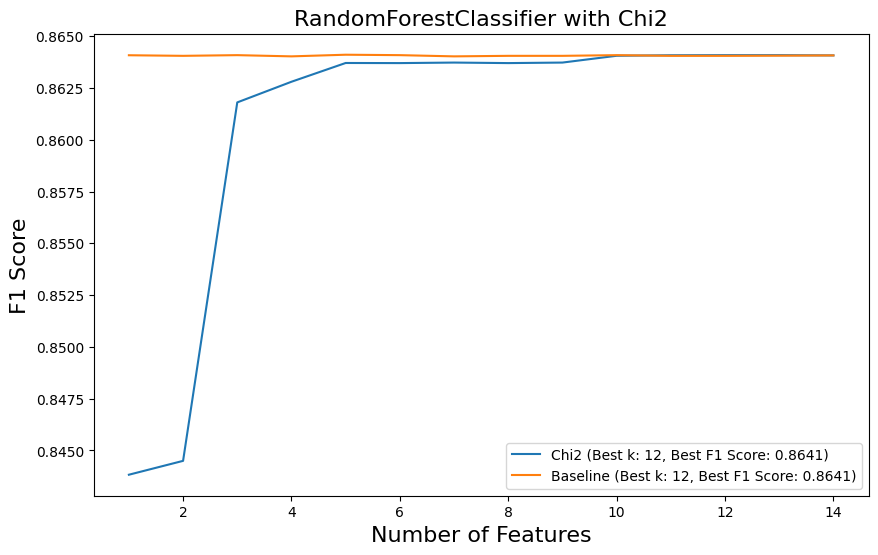

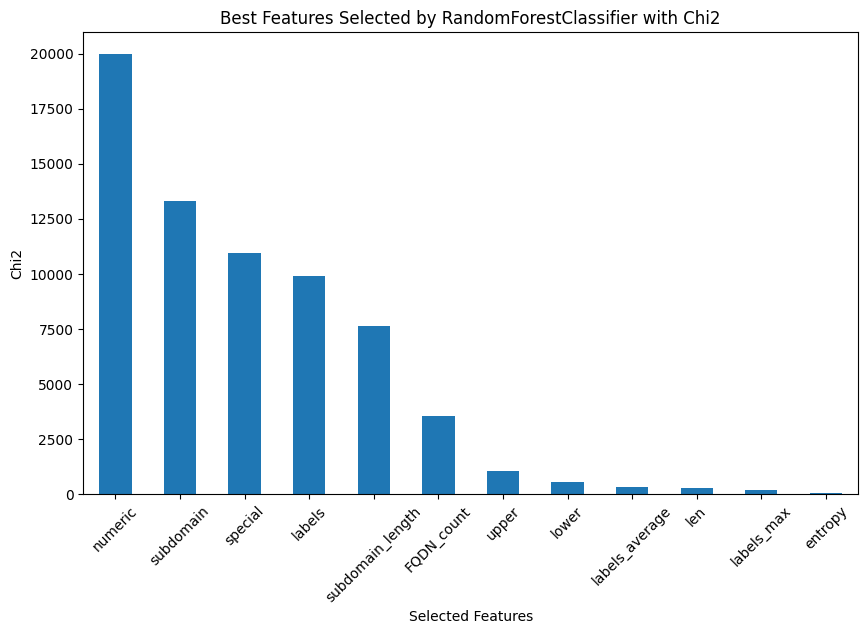

F1 Score (RandomForestClassifier, Chi2): 0.8641
Selected Features (RandomForestClassifier, Chi2):
Index(['numeric', 'subdomain', 'special', 'labels', 'subdomain_length',
       'FQDN_count', 'upper', 'lower', 'labels_average', 'len', 'labels_max',
       'entropy'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76     24116
           1       0.76      1.00      0.86     29499

    accuracy                           0.83     53615
   macro avg       0.88      0.81      0.81     53615
weighted avg       0.87      0.83      0.82     53615



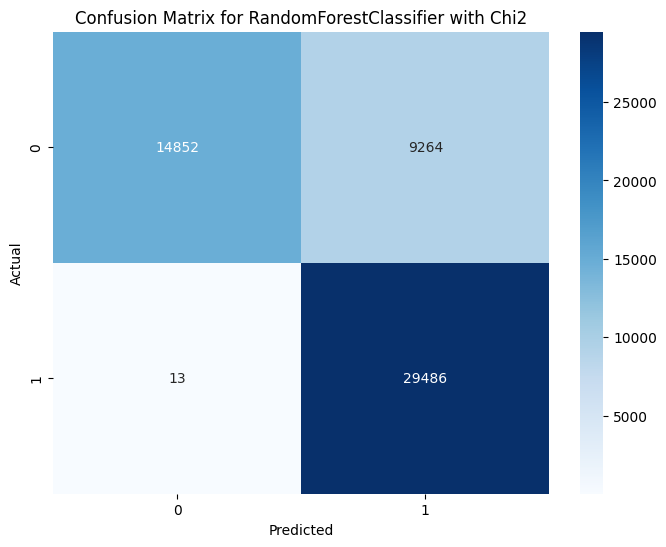

0.8640839291993905

In [264]:
model("RandomForestClassifier", "Chi2", X_train, X_test, y_train, y_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Grid search not applied. Evaluating with the original features.


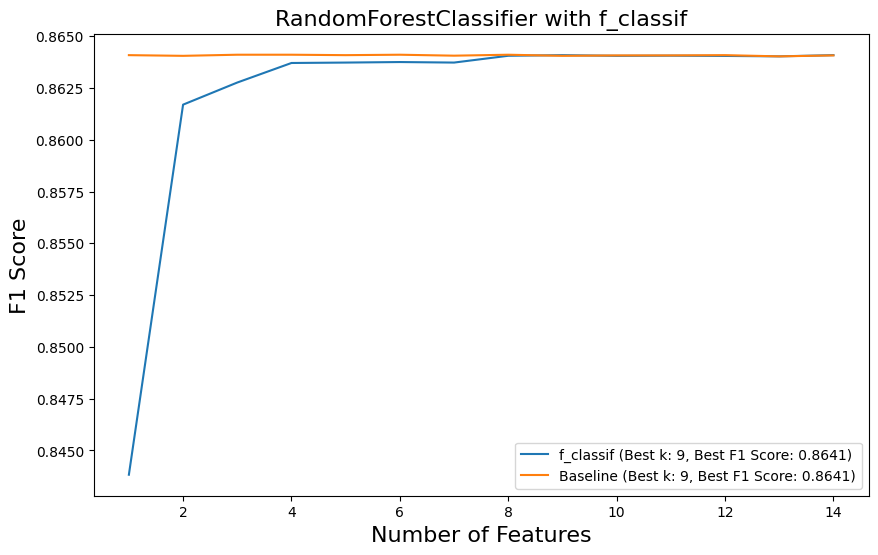

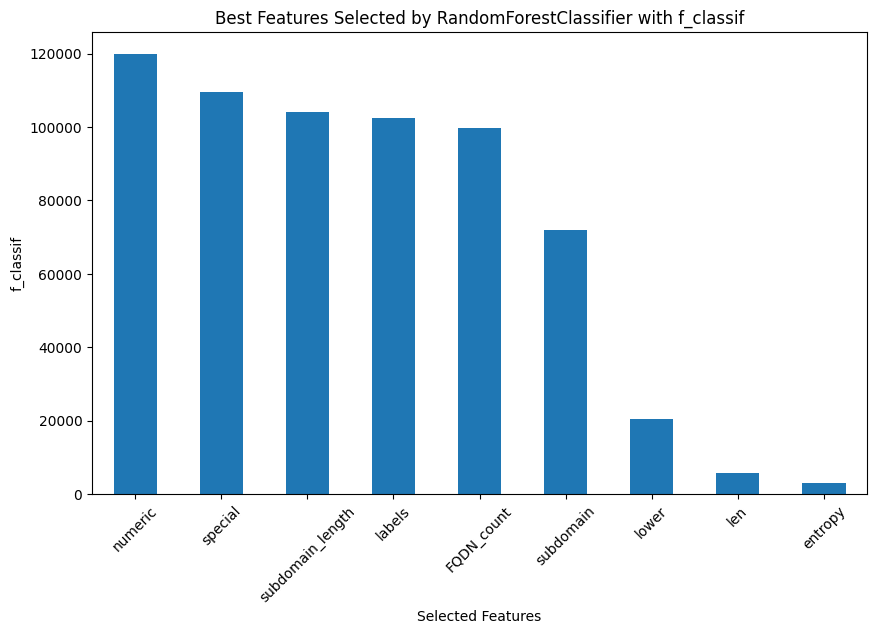

F1 Score (RandomForestClassifier, f_classif): 0.8641
Selected Features (RandomForestClassifier, f_classif):
Index(['numeric', 'special', 'subdomain_length', 'labels', 'FQDN_count',
       'subdomain', 'lower', 'len', 'entropy'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76     24116
           1       0.76      1.00      0.86     29499

    accuracy                           0.83     53615
   macro avg       0.88      0.81      0.81     53615
weighted avg       0.87      0.83      0.82     53615



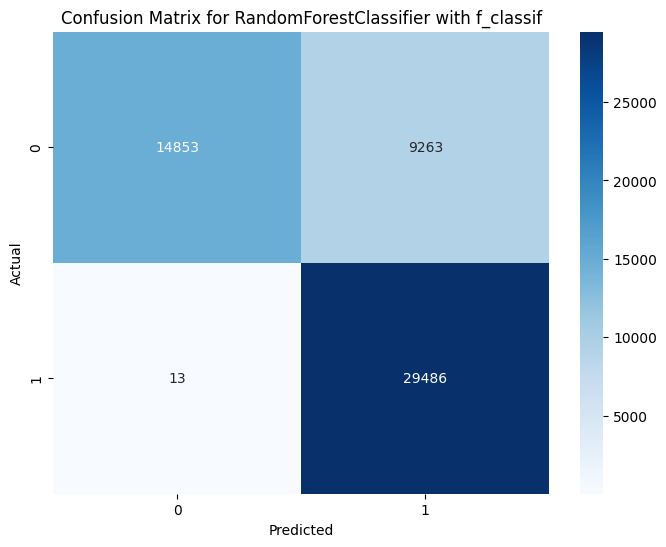

0.8640839291993905

In [233]:
model("RandomForestClassifier", "f_classif", X_train, X_test, y_train, y_test)

Grid search not applied. Evaluating with the original features.


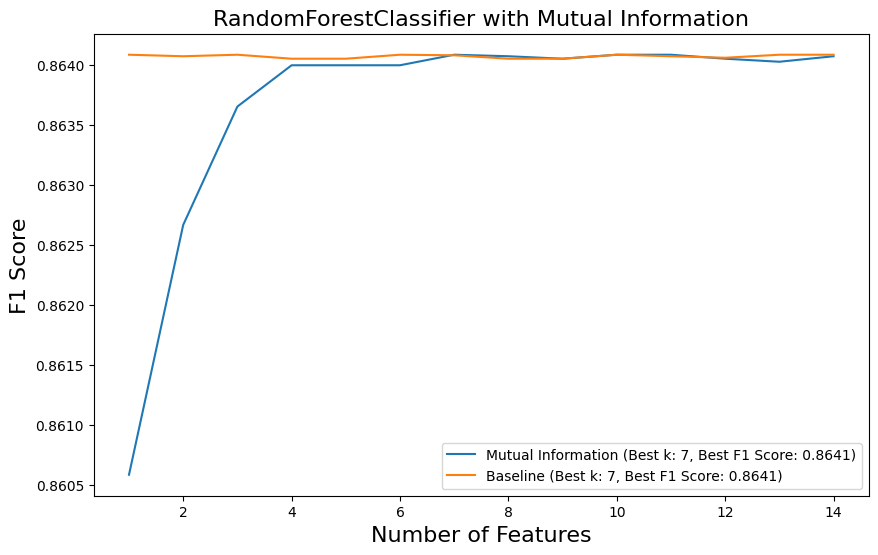

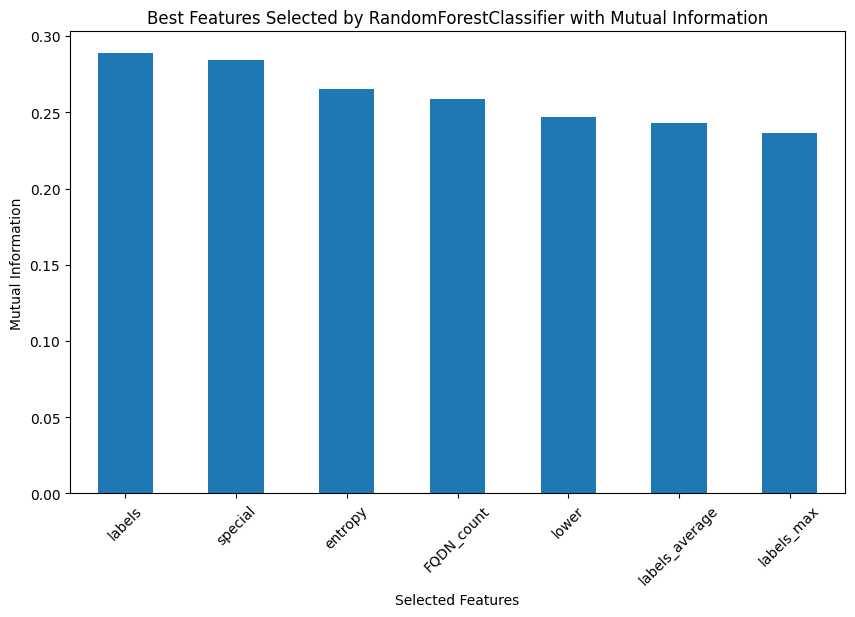

F1 Score (RandomForestClassifier, Mutual Information): 0.8641
Selected Features (RandomForestClassifier, Mutual Information):
Index(['labels', 'special', 'entropy', 'FQDN_count', 'lower', 'labels_average',
       'labels_max'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76     24116
           1       0.76      1.00      0.86     29499

    accuracy                           0.83     53615
   macro avg       0.88      0.81      0.81     53615
weighted avg       0.87      0.83      0.82     53615



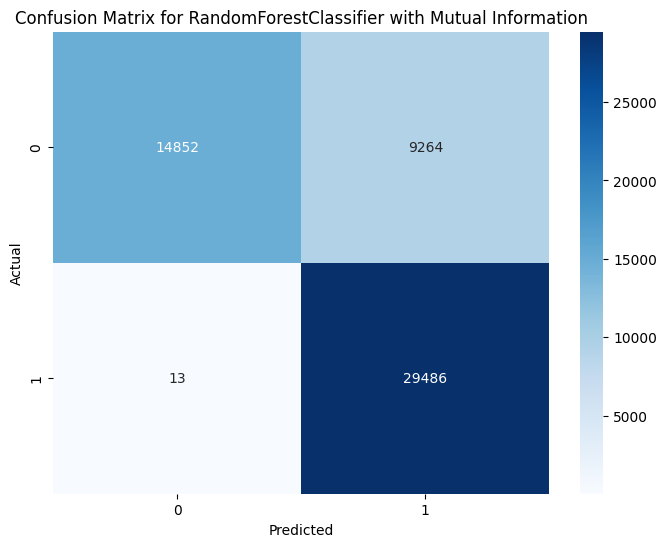

0.8640839291993905

In [252]:
model("RandomForestClassifier", "Mutual Information", X_train, X_test, y_train, y_test)

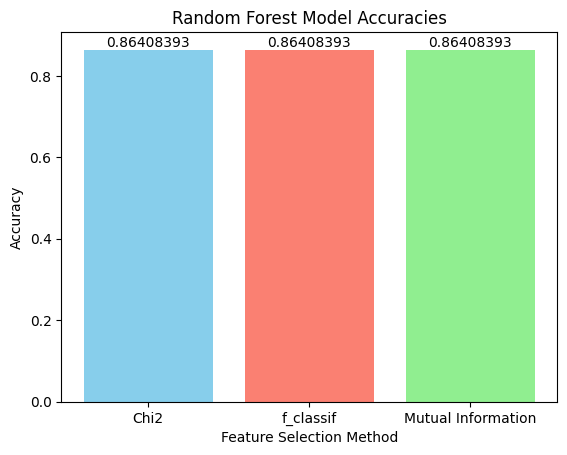

In [269]:
models_names = ['Chi2', 'f_classif', 'Mutual Information']  # Add more if needed
plt.bar(models_names, models_f1_scores_rf, color=['skyblue', 'salmon', 'lightgreen'])  # Adjust colors if needed
plt.title('Random Forest Model Accuracies')
plt.xlabel('Feature Selection Method')
plt.ylabel('Accuracy')

# Annotate the bars with their respective accuracy values
for i, v in enumerate(models_f1_scores_rf):
    plt.text(i, v, f'{v:.8f}', ha='center', va='bottom', fontsize=10)

plt.show()


In [98]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model("RandomForestClassifier", "Mutual Information", X_train, X_test, y_train, y_test, param_grid=param_grid)

Grid Search for RandomForestClassifier with Mutual Information:
Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy after Grid Search: RandomForestClassifier with Mutual Information: 82.5748%


0.8257475772541258

Grid search not applied. Evaluating with the original features.


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

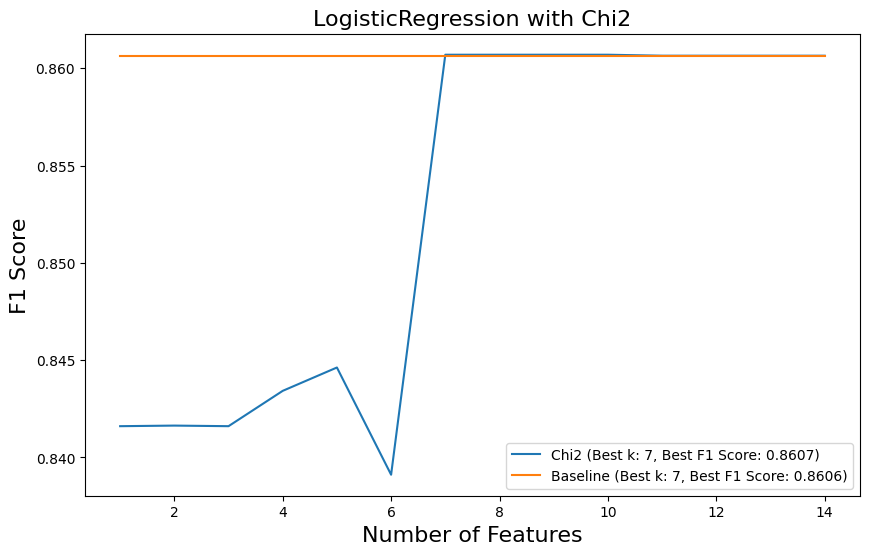

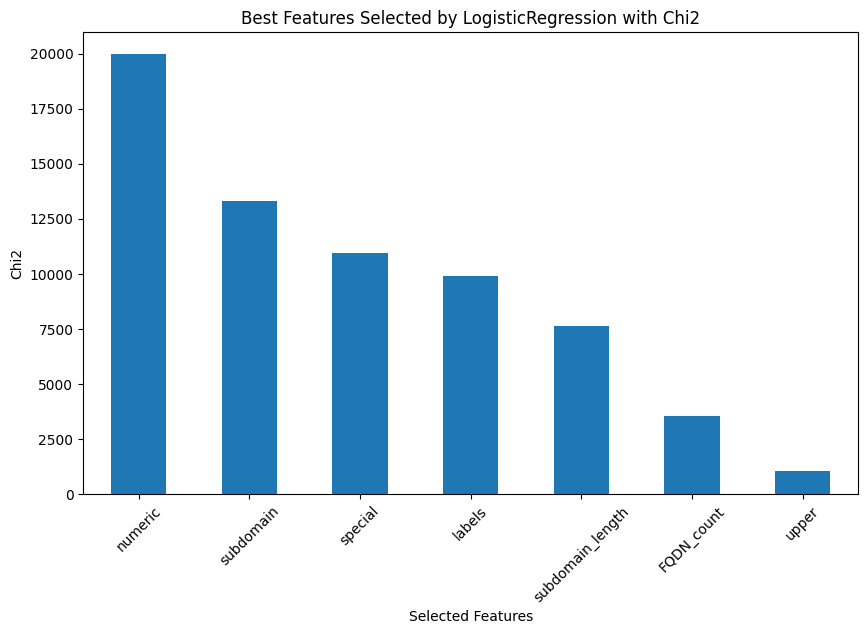

F1 Score (LogisticRegression, Chi2): 0.8607
Selected Features (LogisticRegression, Chi2):
Index(['numeric', 'subdomain', 'special', 'labels', 'subdomain_length',
       'FQDN_count', 'upper'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76     24116
           1       0.76      0.99      0.86     29499

    accuracy                           0.82     53615
   macro avg       0.87      0.80      0.81     53615
weighted avg       0.86      0.82      0.82     53615



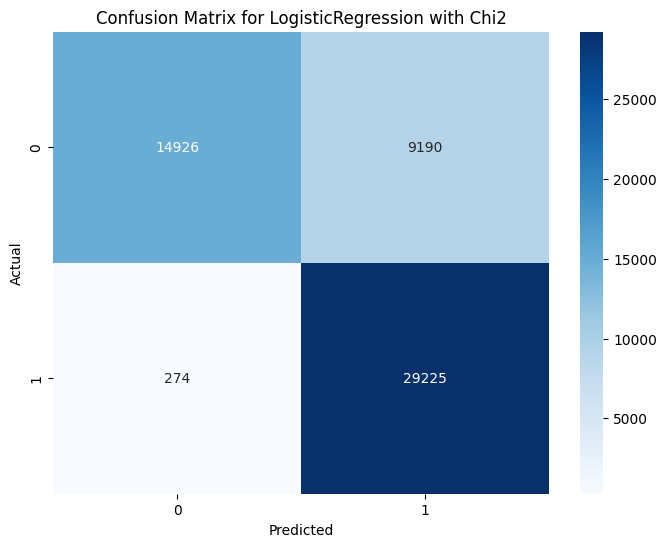

0.8606979826240613

In [270]:
model("LogisticRegression", "Chi2", X_train, X_test, y_train, y_test)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Grid search not applied. Evaluating with the original features.


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

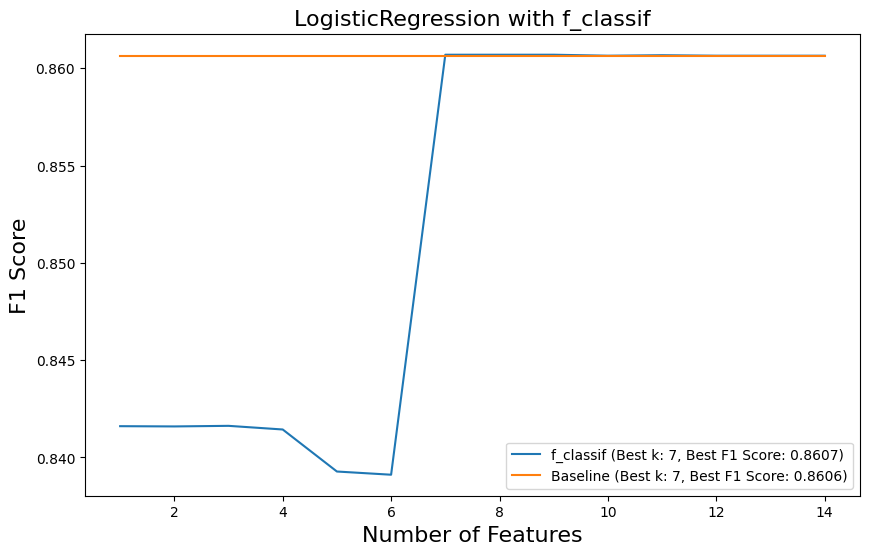

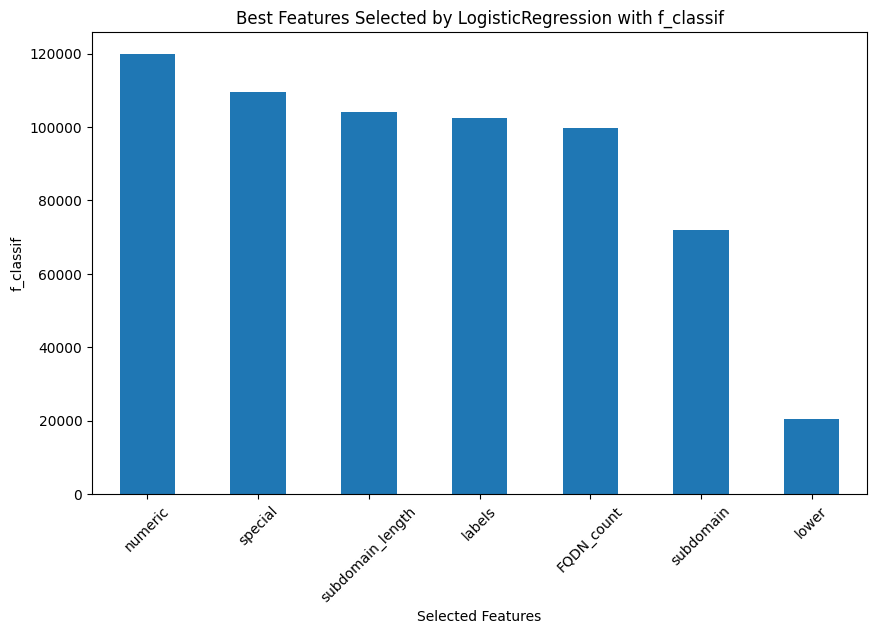

F1 Score (LogisticRegression, f_classif): 0.8607
Selected Features (LogisticRegression, f_classif):
Index(['numeric', 'special', 'subdomain_length', 'labels', 'FQDN_count',
       'subdomain', 'lower'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76     24116
           1       0.76      0.99      0.86     29499

    accuracy                           0.82     53615
   macro avg       0.87      0.80      0.81     53615
weighted avg       0.86      0.82      0.82     53615



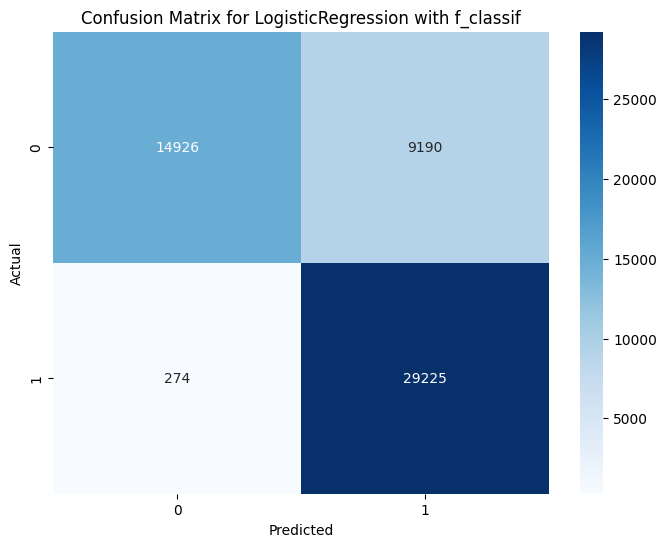

0.8606979826240613

In [271]:
model("LogisticRegression", "f_classif", X_train, X_test, y_train, y_test)


Grid search not applied. Evaluating with the original features.


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

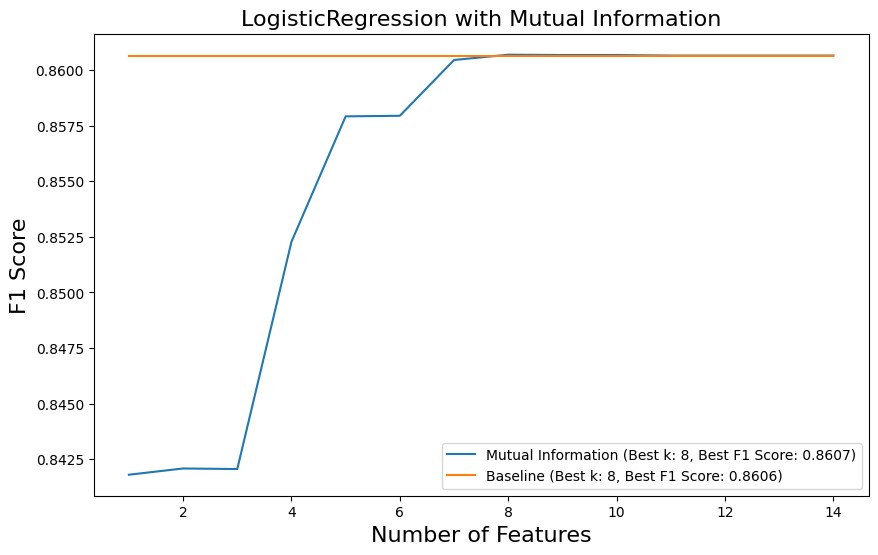

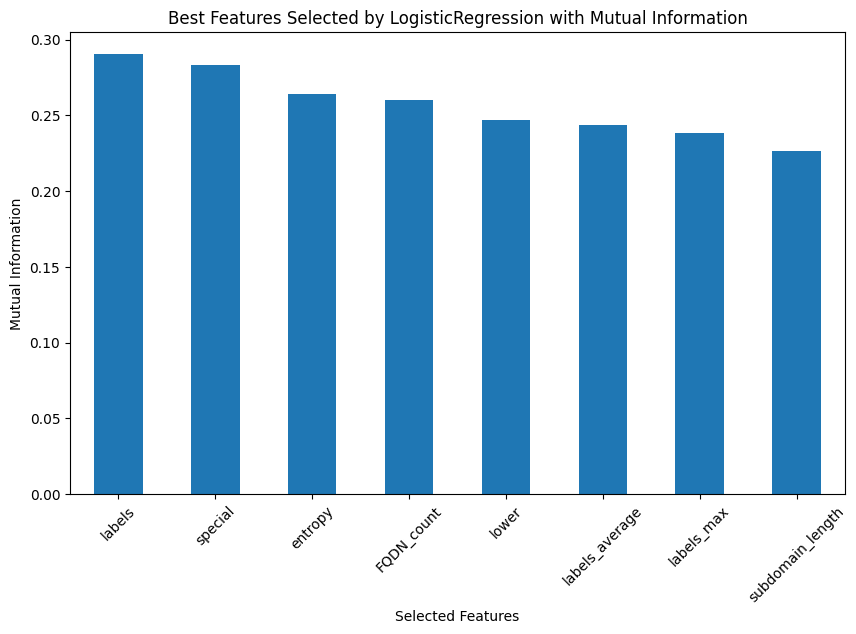

F1 Score (LogisticRegression, Mutual Information): 0.8607
Selected Features (LogisticRegression, Mutual Information):
Index(['labels', 'special', 'entropy', 'FQDN_count', 'lower', 'labels_average',
       'labels_max', 'subdomain_length'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76     24116
           1       0.76      0.99      0.86     29499

    accuracy                           0.82     53615
   macro avg       0.87      0.80      0.81     53615
weighted avg       0.86      0.82      0.82     53615



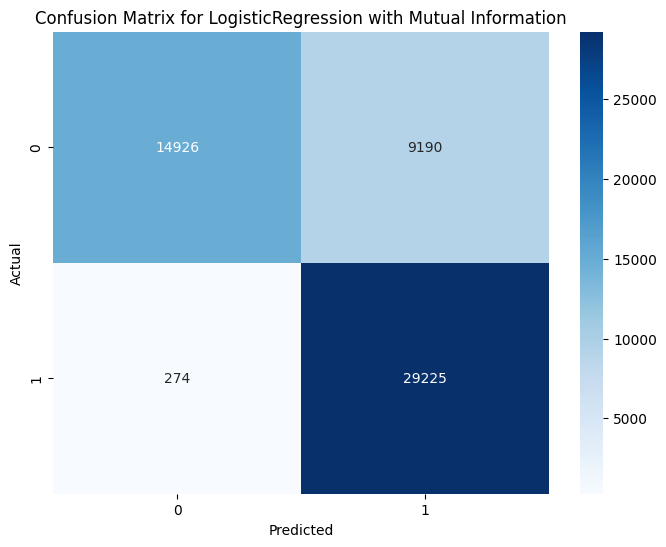

0.8606853087128742

In [272]:
model("LogisticRegression", "Mutual Information", X_train, X_test, y_train, y_test)


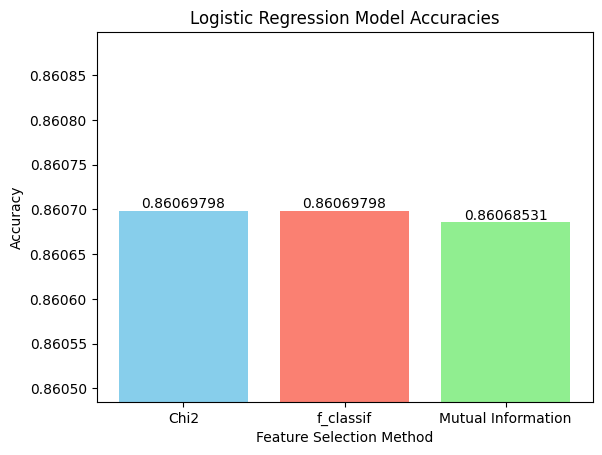

In [310]:
# For the Logistic Regression Model Accuracies
models_names = ['Chi2', 'f_classif', 'Mutual Information']
plt.bar(models_names, models_f1_scores_lr, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Logistic Regression Model Accuracies')
plt.xlabel('Feature Selection Method')
plt.ylabel('Accuracy')

# Set the y-axis limit to emphasize differences
plt.ylim(min(models_f1_scores_lr) - 0.0002, max(models_f1_scores_lr) + 0.0002)

# Annotate the bars with their respective accuracy values
for i, v in enumerate(models_f1_scores_lr):
    plt.text(i, v, f'{v:.8f}', ha='center', va='bottom', fontsize=10)

plt.show()


In [102]:
# Logistic Regression parameter grid
logistic_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 100, 200]
}

# Example usage for Logistic Regression with grid search
model("LogisticRegression", "f_classif", X_train, X_test, y_train, y_test, param_grid=logistic_param_grid)



c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Grid Search for LogisticRegression with f_classif:


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best hyperparameters: {'C': 0.01, 'max_iter': 200}
Accuracy after Grid Search: LogisticRegression with f_classif: 82.4013%


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8240129795736106

In [276]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

scores = mutual_info_classif(X_train, y_train)
scores_series = pd.Series(scores, index=X_train.columns)

# Initialize the RandomForestClassifier
model = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("F1 Score:", f1)


Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
F1 Score: 0.8640839291993905


In [279]:
# Save the best model with the selected features
selected_features = [
    'labels', 'special', 'entropy', 'FQDN_count', 'lower', 'labels_average', 'labels_max'
]


best_params = {'max_depth': 20, 'min_samples_leaf': 1 , 'min_samples_split': 5 ,'n_estimators': 100 } 
model = RandomForestClassifier(**best_params)

model_data = {
    'model': model,
    'selected_features': selected_features,
    'best_params': best_params
}

filename = 'randomforestclassifier_mutual information_model_results.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_data, file)


In [298]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score

# Initialize SelectKBest with f_classif
feature_selector = SelectKBest(score_func=f_classif)

# Fit and transform the feature selection on training data
X_train_selected = feature_selector.fit_transform(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Initialize the Logistic Regression model
model = LogisticRegression()

# Perform Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Transform the test set using the selected features
X_test_selected = feature_selector.transform(X_test)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_selected)
f1 = f1_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("F1 Score:", f1)


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converg

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
F1 Score: 0.8623012902373508


In [299]:
models_f1_scores=[0.8623012902373508,0.8640839291993905]

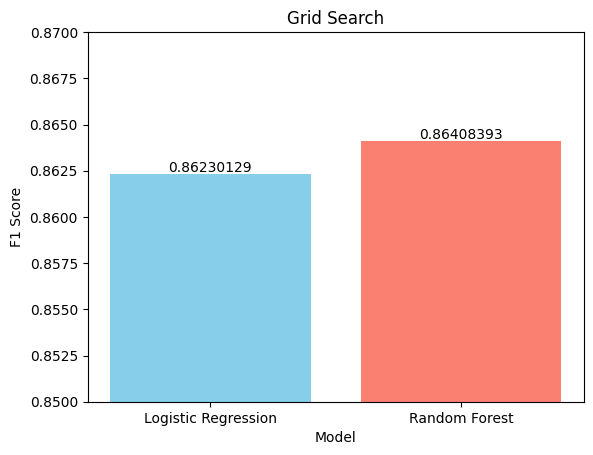

In [301]:
plt.ylim(0.85, 0.87)  # Adjust the range according to your f1 scores

plt.bar(models_names, models_f1_scores, color=['skyblue', 'salmon'])
plt.title('Grid Search')
plt.xlabel('Model')
plt.ylabel('F1 Score')

for i, v in enumerate(models_f1_scores):
    plt.text(i, v, f'{v:.8f}', ha='center', va='bottom', fontsize=10)

plt.show()
